In [28]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
random_seed=12321132

In [3]:
words = open("names.txt", 'r').read().splitlines()

words[:4]

['emma', 'olivia', 'ava', 'isabella']

## MLP

Implementation - 

1. Create training data - Xs and Ys. Depending upon the context length, we need to create a training data.
2. Initialise the weights
3. Forward pass -
   1. Calculate the logits
   2. Calculate the losss  
4. Backward pass -
   1. Calculate the gradients
5. Update the weights

### Create Training data

In [5]:
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

In [10]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        w += '.'
        context = [0] * block_size
        for s in w:
            ix = stoi[s]
            X.append(context)
            Y.append(ix)
            # print(f'{"".join(itos[i] for i in context)} ===> {s}')
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(random_seed)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte   = build_dataset(words[n2:])

torch.Size([182411, 3]) torch.Size([182411])
torch.Size([22843, 3]) torch.Size([22843])
torch.Size([22892, 3]) torch.Size([22892])


### Initialise the Weights

In [50]:
n_emb = 10      # embedding size for all inputs
n_hidden = 200 # count of neurons in hidden layer.

In [51]:
g = torch.Generator().manual_seed(random_seed)

C = torch.randn((vocab_size, n_emb),               generator = g)                # embedding matrix
W1 = torch.randn((block_size * n_emb, n_hidden),   generator = g)                # hidden layer weights
b1 = torch.randn((n_hidden),                       generator = g)                # hidden layer biases
W2 = torch.randn((n_hidden, vocab_size),           generator = g)                # output layer weights
b2 = torch.randn((vocab_size),                     generator = g)                # output layer biases

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

11897


### Forward pass

In [52]:
max_steps  = 200_000
batch_size = 32
lossi      = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 10**-.5 if i < 100_000 else 10**-1.5
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 10_000 ==0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
# e = torch.exp(logits)
# probs = (e/e.sum(1, keepdim=True))
# probs[torch.arange(probs.shape[0]), Ytr]

# emb.shape, h.shape, logits.shape, 

      0/ 200000 : 21.1907
  10000/ 200000 : 3.8238
  20000/ 200000 : 4.7174
  30000/ 200000 : 4.2764
  40000/ 200000 : 2.7409
  50000/ 200000 : 1.9296
  60000/ 200000 : 2.7317
  70000/ 200000 : 2.6177
  80000/ 200000 : 2.2628
  90000/ 200000 : 3.1175
 100000/ 200000 : 2.7993
 110000/ 200000 : 2.1162
 120000/ 200000 : 2.5089
 130000/ 200000 : 2.2619
 140000/ 200000 : 2.3801
 150000/ 200000 : 2.3790
 160000/ 200000 : 1.8732
 170000/ 200000 : 2.1140
 180000/ 200000 : 2.1292
 190000/ 200000 : 1.7274


In [53]:
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 
            'dev': (Xdev, Ydev),
            'test':(Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train: 2.0979
dev: 2.1581


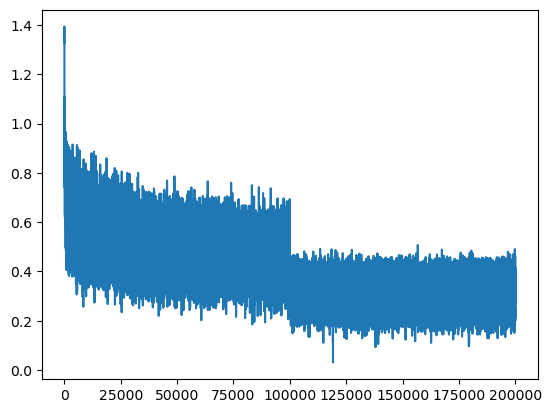

In [54]:
plt.plot(lossi)